<a href="https://colab.research.google.com/github/qmffkem/learning-makemore/blob/main/JaeungJang_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the beginning of the colab.

Here is the video link:
https://www.youtube.com/watch?v=TCH_1BHY58I


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
!curl https://raw.githubusercontent.com/karpathy/makemore/master/names.txt > names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0  1367k      0 --:--:-- --:--:-- --:--:-- 1375k


In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vacabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [222]:
#build the dataset

block_size = 3
X, Y = [], []
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print("".join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append


X = torch.tensor(X)
Y = torch.tensor(Y)

In [223]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [232]:
# build the dataset

def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182535, 3]) torch.Size([182535])
torch.Size([22762, 3]) torch.Size([22762])
torch.Size([22849, 3]) torch.Size([22849])


In [ ]:
C = torch.randn((27, 2))

In [ ]:
emb = C[X] # for each indices in X, it finds the matching one from C, so that's why size becomes [32, 3, 2]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
emb[:, 0].shape

torch.Size([32, 2])

In [ ]:
# torch.cat(torch.unbind(emb, 1), 1) @ W1 + b1  # you can use unbind to create or use view
h = emb.view(emb.shape[0], 6) @ W1 + b1

In [ ]:
h.shape

torch.Size([32, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

torch.Size([32, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(37.9526)

combine all together

In [ ]:
# ----------------- now maded respectable ------------------

In [284]:
Xtr.shape, Ytr.shape

(torch.Size([182535, 3]), torch.Size([182535]))

In [287]:
C = torch.randn((27, 10))
W1 = torch.randn((30,200))
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

In [289]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [290]:
for p in parameters:
  p.requires_grad = True

In [291]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [292]:
lri = []
lossi = []
stepi = []

In [302]:
for i in range(50000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] #(32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())
  stepi.append(i)
  lossi.append(loss.log10().item())

# print(loss.item())

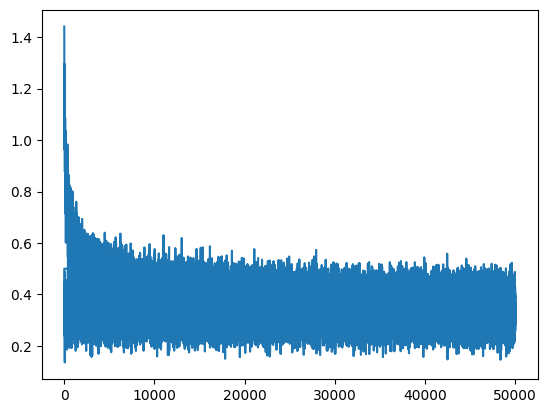

In [303]:
plt.plot(stepi, lossi)

In [304]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1647, grad_fn=<NllLossBackward0>)

In [306]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2111, grad_fn=<NllLossBackward0>)

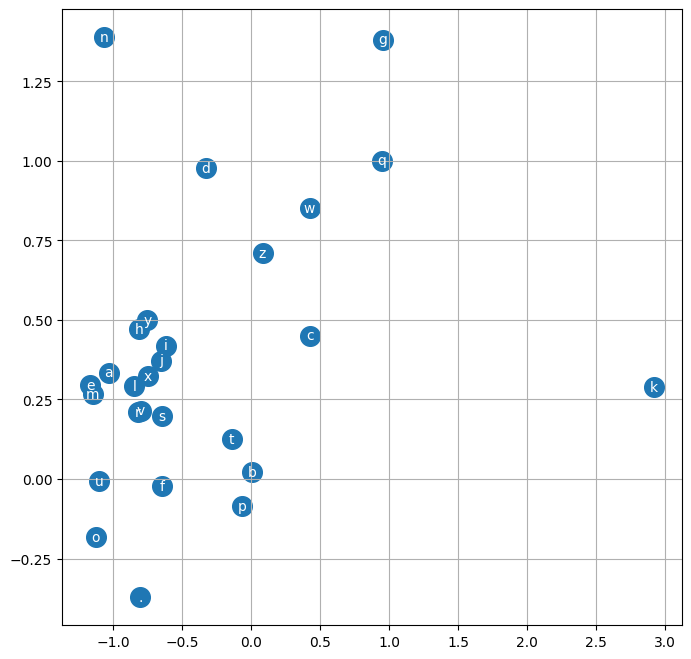

In [307]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [255]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.3378, grad_fn=<NllLossBackward0>)

In [311]:

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

eri.
aanisome.
avee.
muriarro.
saberusel.
dela.
janahia.
umb.
gana.
tiyah.
arekton.
lek.
reon.
arhellen.
luye.
dayabkennadi.
zia.
elony.
nevy.
kaelyganelle.
